In [2]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.stats.api as sms
import statsmodels.formula.api as smf

from src.utils import load, add_variables, clean_data
from src.preprocessing import DataSet
from src.forecast import NaiveDrift, NaiveLast, NaiveSeasonal, NaiveAVG, TSCV, OLS
from src.ploting import LinearPlot, DistPlot, ACFPlot
from src.utils.hellwig import run_hellwig

pd.set_option("display.max_rows", 200)
pd.set_option("display.max_columns", 50)

In [3]:
CURRENCY = "EURUSD"
INTERVAL = "15m"

## Podział na zbiory train, test, validate

In [4]:
eurusd = load(currency=CURRENCY, interval=INTERVAL)
data = DataSet(data=eurusd, ratios=[0.9, 0.1], label=['target_direction', 'target_value'])
train, val, test = data.add_variables().clean_data().normalize(how="standarize").get_tvt_df()

# Metody naiwne

In [5]:
eurusd = load(currency=CURRENCY, interval=INTERVAL)
eurusd = clean_data(eurusd)
data = DataSet(data=eurusd, ratios=[0.95, 0.05], label=['target_value'])
tscv = TSCV(dataset=data,
            n_splits=20,
            test_size=5)

In [6]:
results = {'sns': {}, 'avg': {}, 'drift': {}, 'last': {}}
pred = {'sns': [], 'avg': [], 'drift': [], 'last': []}

tscv.run(model=NaiveSeasonal(), h=5, k=4, norm_type="standarize")
results['sns'] = tscv.metric_values
pred['sns'] = tscv.predicted
print("sns")

avg = tscv.run(model=NaiveAVG(), h=5, T=4, norm_type="standarize")
results['avg'] = tscv.metric_values
pred['avg'] = tscv.predicted
print("avg")

drift = tscv.run(model=NaiveDrift(), h=5, norm_type="standarize")
results['drift'] = tscv.metric_values
pred['drift'] = tscv.predicted
print("drift")

last = tscv.run(model=NaiveLast(), h=5, norm_type="standarize")
results['last'] = tscv.metric_values
pred['last'] = tscv.predicted
print("last")

sns
avg
drift
last


In [7]:
pd.DataFrame().from_dict(results).transpose().applymap(round, ndigits=5)

,mean_absolute_percentage_error,rmspe
sns,0.00063,0.00074
avg,0.00047,0.00056
drift,0.00115,0.00128
last,0.00065,0.00082


<Axes: title={'center': 'Metody Naiwne'}>

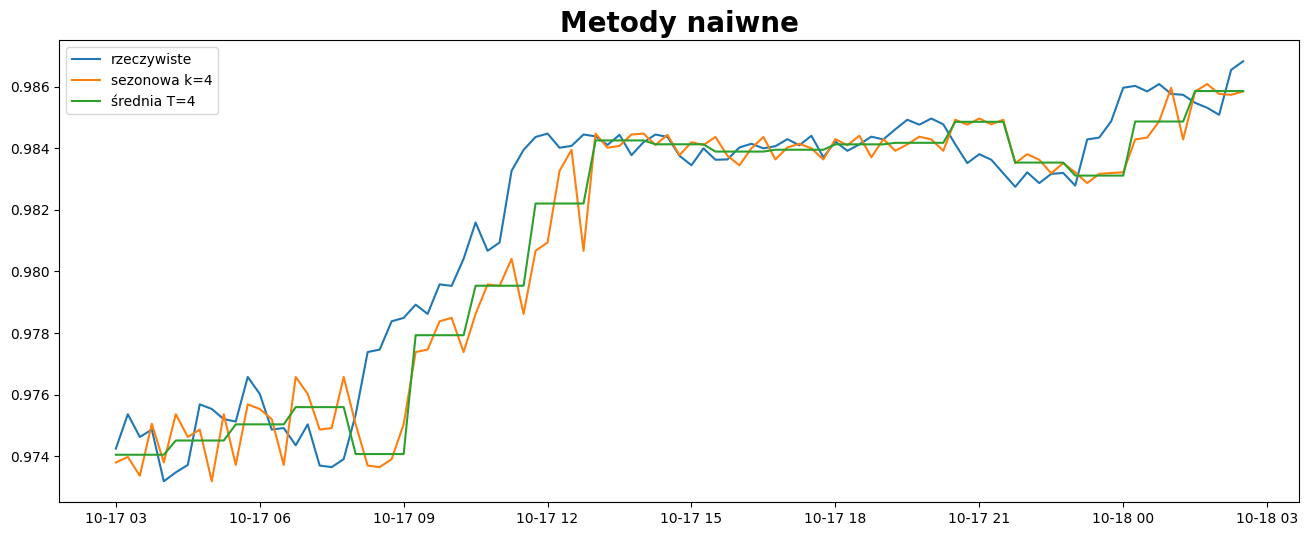

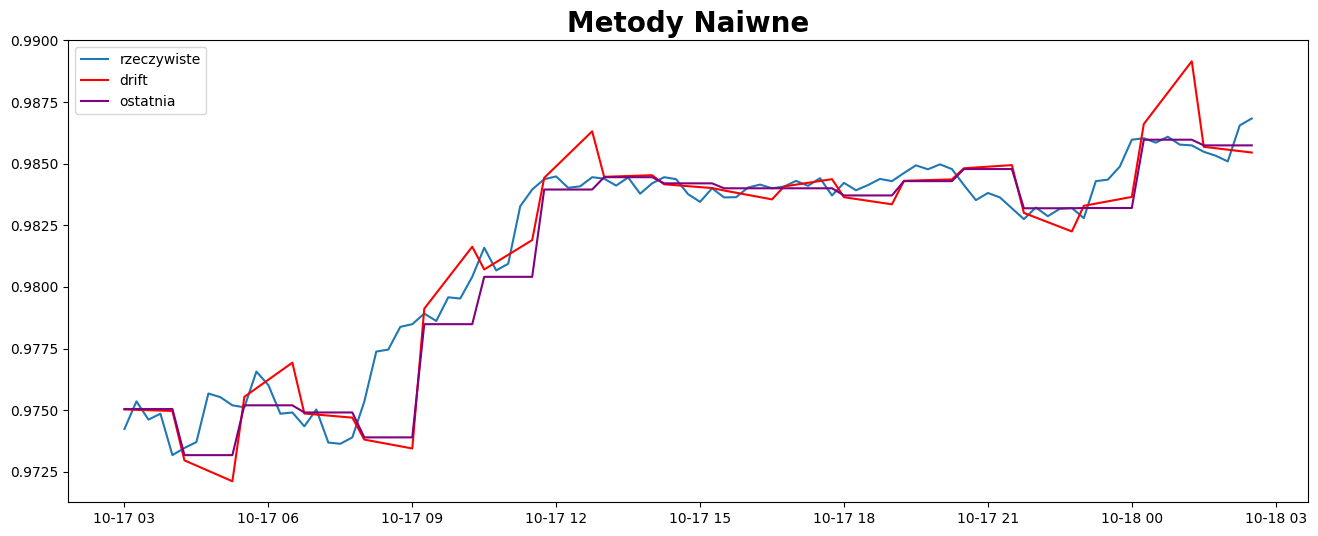

In [8]:
label = 'target_value'
train, test = tscv.dataset.train, tscv.dataset.test

x = tscv.dataset.data.index[-95:]

lp = LinearPlot(legend=True, h=6, w=16)
lp.plot(x, tscv.dataset.data.loc[x, label], label="rzeczywiste", title="Metody naiwne")
lp.plot(x, pred['sns'][:-5], label="sezonowa k=4")
lp.plot(x, pred['avg'][:-5], label="średnia T=4")

lp = LinearPlot(legend=True, h=6, w=16)
lp.plot(x, tscv.dataset.data.loc[x, label], label="rzeczywiste", title="Metody Naiwne")
lp.plot(x, pred['drift'][:-5], label="drift", color="red")
lp.plot(x, pred['last'][:-5], label="ostatnia", color="purple")

# MNK

In [9]:
tscv.run(model=OLS())
results['ols'] = tscv.metric_values
pred['ols'] = tscv.predicted

In [10]:
results['ols']

{'mean_absolute_percentage_error': 0.0005150034067329989,
 'rmspe': 0.0007652415172571749}

In [11]:
pd.DataFrame(results['ols'], index=[0])

,mean_absolute_percentage_error,rmspe
0,0.000515,0.000765


<Axes: title={'center': 'Metoda Najmniejszych Kwadratów'}>

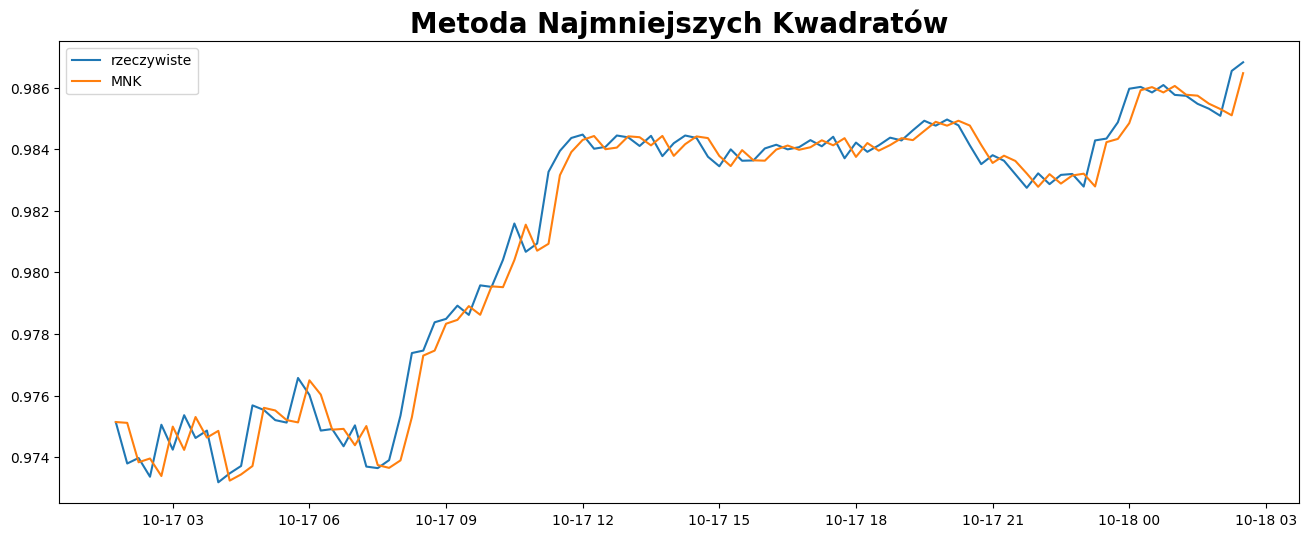

In [12]:
x = tscv.dataset.data.index[-100:]

lp = LinearPlot(legend=True, h=6, w=16)
lp.plot(x, tscv.dataset.data.loc[x, 'target_value'], label="rzeczywiste", title="Metoda Najmniejszych Kwadratów")
lp.plot(x, pred['ols'], label="MNK")

## Hellwig's method for choosing features

In [13]:

eurusd = tscv.dataset.train

Drop features with negligible correlation with label, high correlation between each other and low coefficient of variation

In [14]:
FEATURES = ['Close', 'Volume', 'roi_5',
       'roi_10', 'roi_20', 'candle_body_size', 'vol_change_1', 'vol_change_2',
       'vol_change_3', 'sma_50', 'candle_size',
       'impulse', 'hour_0', 'hour_1', 'hour_2', 'hour_3', 'hour_4', 'hour_5',
       'hour_6', 'hour_7', 'hour_8', 'hour_9', 'hour_10', 'hour_11', 'hour_12',
       'hour_13', 'hour_14', 'hour_15', 'hour_16', 'hour_17', 'hour_18',
       'hour_19', 'hour_20', 'hour_21', 'hour_22', 'hour_23', 'weekday_0',
       'weekday_1', 'weekday_2', 'weekday_3', 'weekday_4', 'weekday_5',
       'weekday_6']

In [15]:
cv = eurusd[FEATURES].std()/eurusd[FEATURES].mean()*100
cv.apply(lambda x: f"{int(x)}%")

Close                    8%
Volume                  99%
roi_5               -21484%
roi_10              -14158%
roi_20               -9719%
candle_body_size    -29095%
vol_change_1          4345%
vol_change_2          5165%
vol_change_3          4720%
sma_50                   8%
candle_size             81%
impulse                325%
hour_0                 260%
hour_1                 300%
hour_2                 303%
hour_3                 302%
hour_4                 301%
hour_5                 301%
hour_6                 300%
hour_7                 299%
hour_8                 298%
hour_9                 297%
hour_10                296%
hour_11                296%
hour_12                295%
hour_13                295%
hour_14                295%
hour_15                296%
hour_16                297%
hour_17                298%
hour_18                299%
hour_19                300%
hour_20                301%
hour_21                298%
hour_22                255%
hour_23             

In [16]:
FEATURES.remove('sma_50')

Close and sma_50 have coefficient of variance below 10%, therefore are eliminated from possible features group

In [17]:
run_hellwig(df=eurusd, cols=FEATURES[:12])

0
12
78
298
793
1585
2509
3301
3796
4016
4082
4094
0/4095
1/4095
2/4095
3/4095
4/4095
5/4095
6/4095
7/4095
8/4095
9/4095
10/4095
11/4095
12/4095
13/4095
14/4095
15/4095
16/4095
17/4095
18/4095
19/4095
20/4095
21/4095
22/4095
23/4095
24/4095
25/4095
26/4095
27/4095
28/4095
29/4095
30/4095
31/4095
32/4095
33/4095
34/4095
35/4095
36/4095
37/4095
38/4095
39/4095
40/4095
41/4095
42/4095
43/4095
44/4095
45/4095
46/4095
47/4095
48/4095
49/4095
50/4095
51/4095
52/4095
53/4095
54/4095
55/4095
56/4095
57/4095
58/4095
59/4095
60/4095
61/4095
62/4095
63/4095
64/4095
65/4095
66/4095
67/4095
68/4095
69/4095
70/4095
71/4095
72/4095
73/4095
74/4095
75/4095
76/4095
77/4095
78/4095
79/4095
80/4095
81/4095
82/4095
83/4095
84/4095
85/4095
86/4095
87/4095
88/4095
89/4095
90/4095
91/4095
92/4095
93/4095
94/4095
95/4095
96/4095
97/4095
98/4095
99/4095
100/4095
101/4095
102/4095
103/4095
104/4095
105/4095
106/4095
107/4095
108/4095
109/4095
110/4095
111/4095
112/4095
113/4095
114/4095
115/4095
116/4095
117/40

In [18]:
tscv.dataset.data = tscv.dataset.data[['Close', 'target_value']]

Build and fit model

In [42]:
tscv.run(model=OLS())

{'mean_absolute_percentage_error': 0.00052205706, 'rmspe': 0.0007757699}

In [43]:
x, y = tscv.dataset.train['Close'].values.reshape(-1, 1), tscv.dataset.train['target_value'].values
tscv.model.summary()

'const: [-0.00017846]\n coef: [[1.0001488]]\n R-score: 0.9999592349843747'

### STATSMODELS model

In [21]:
import statsmodels.api as sm
train_x, train_y = tscv.dataset.train['Close'],  tscv.dataset.train['target_value']

model = sm.OLS(train_x, train_y).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                  Close   R-squared (uncentered):                   1.000
Model:                            OLS   Adj. R-squared (uncentered):              1.000
Method:                 Least Squares   F-statistic:                          9.643e+11
Date:                Wed, 19 Apr 2023   Prob (F-statistic):                        0.00
Time:                        21:41:09   Log-Likelihood:                      1.6453e+06
No. Observations:              277128   AIC:                                 -3.291e+06
Df Residuals:                  277127   BIC:                                 -3.291e+06
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
target_value     1.0000   1.02e-06   9.82e+05      0.000       1.000       1.000
==============================================================================
Omnibus:                    77224.884   Durbin-Watson:                   2.036
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          9592566.061
Skew:                           0.015   Prob(JB):                         0.00
Kurtosis:                      31.823   Cond. No.                         1.00
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

## Residuals normal distribution

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


<Axes: title={'center': 'Wykres liniowy reszt MNK'}>

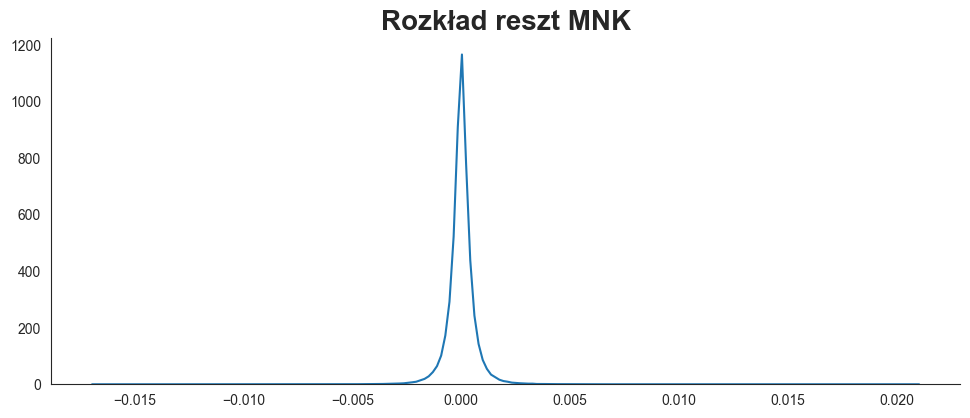

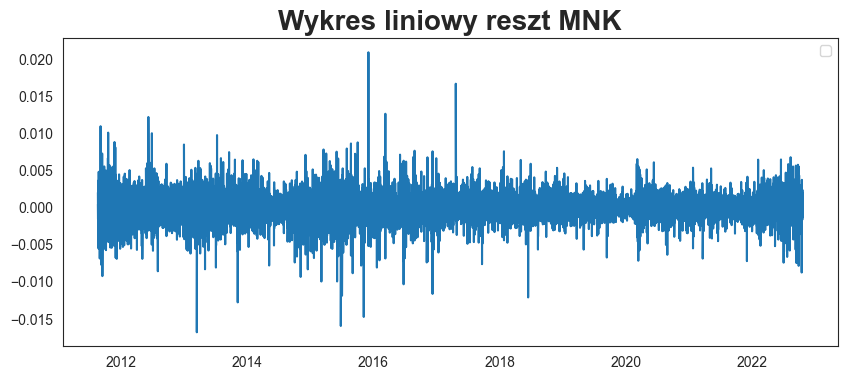

In [22]:
DistPlot().plot(tscv.residuals, title="Rozkład reszt MNK")
LinearPlot().plot(tscv.dataset.train.index, tscv.residuals, title="Wykres liniowy reszt MNK")

JB-Test

In [23]:
from scipy.stats import jarque_bera
jarque_bera(tscv.residuals)

SignificanceResult(statistic=9577441.906042287, pvalue=0.0)

In [24]:
from scipy.stats import kstest
from scipy import stats
kstest(tscv.residuals, stats.norm.cdf)

KstestResult(statistic=0.49764159938120844, pvalue=0.0, statistic_location=0.0046453476, statistic_sign=1)

In [25]:
print(f"skewenes: {stats.skew(tscv.residuals)}\nkurtosis: {stats.kurtosis(tscv.residuals)}")

-0.020758218686628728

28.799817056724432

## Residuals heteroscedasity

In [27]:
fit = smf.ols('target_value ~ Close', data=tscv.dataset.train).fit()
names = ['Lagrange multiplier statistic', 'p-value',
         'f-value', 'f p-value']
breush = sms.het_breuschpagan(fit.resid, fit.model.exog)
list(zip(names, breush))

[('Lagrange multiplier statistic', 64.46365695164214),
 ('p-value', 9.832943073560921e-16),
 ('f-value', 64.47819020927416),
 ('f p-value', 9.798483495315656e-16)]

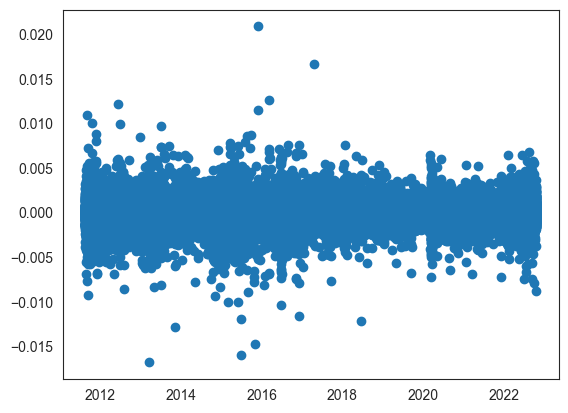

In [28]:
plt.scatter(tscv.dataset.train.index, tscv.residuals)

## Residuals autocorellation

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


<Axes: title={'center': 'ACF reszt'}>

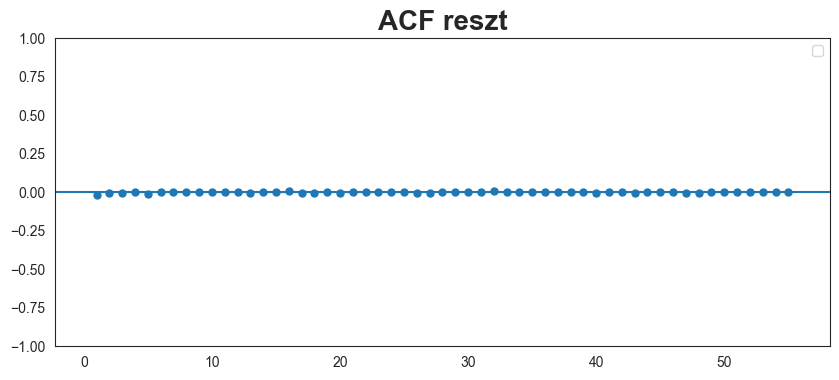

In [29]:
ACFPlot().plot(tscv.residuals, title="ACF reszt")

/Users/sebastiansukiennik/.pyenv/versions/3.9.6/envs/BACH/lib/python3.9/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


<Axes: title={'center': 'PACF reszt'}>

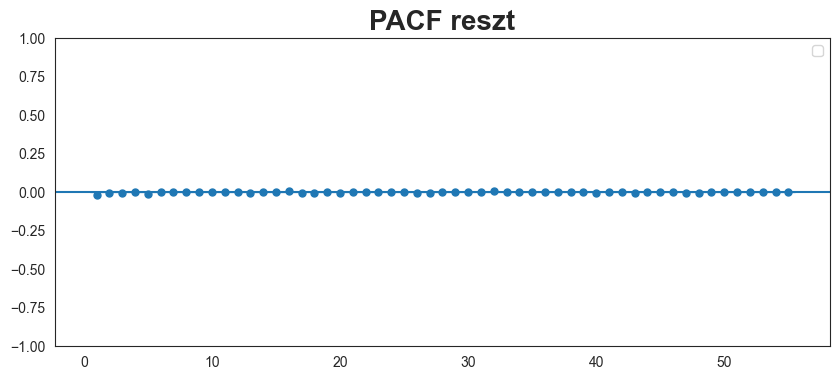

In [30]:
ACFPlot().plot(tscv.residuals, partial=True, title="PACF reszt")

In [31]:
from statsmodels.stats.stattools import durbin_watson
durbin_watson(tscv.residuals)

2.0346088

In [32]:
from statsmodels.stats.outliers_influence import variance_inflation_factor


## Chow's test

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


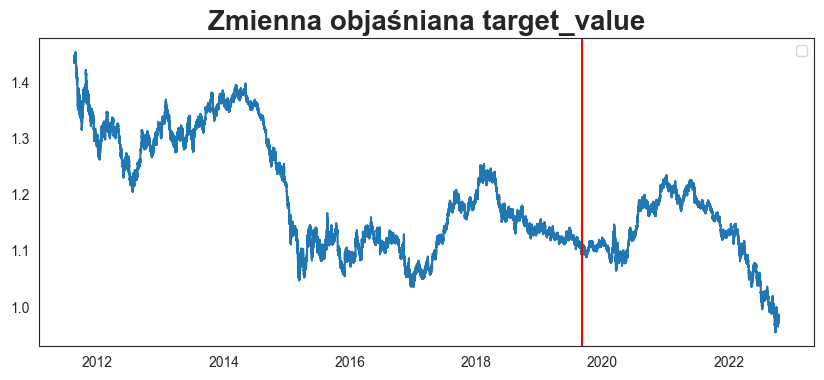

In [33]:
LinearPlot().plot(tscv.dataset.train.index, tscv.dataset.train['target_value'], title="Zmienna objaśniana target_value").\
    axvline(x=tscv.dataset.train.index[200000], color='red')

In [34]:
from chow_test import chow_test
X, y = tscv.dataset.train['Close'], tscv.dataset.train['target_value']
chow_test(X, y, last_index=199999, first_index=200000, significance=0.05)

Reject the null hypothesis of equality of regression coefficients in the two periods.
Chow Statistic: 102.39090561545422, P_value: 1.1102230246251565e-16


(102.39090561545422, 1.1102230246251565e-16)

## Models Coincidence

In [44]:
R_0 = tscv.dataset.train.corr()
R_0

,Close,target_value
Close,1.00000,0.99998
target_value,0.99998,1.00000


In [45]:
tscv.model.summary()

'const: [-0.00017846]\n coef: [[1.0001488]]\n R-score: 0.9999592349843747'

## Eliminate heteroscedascity 

1. Y = a*log(X) + b

In [103]:
data = tscv.dataset.train.copy().assign(
    Close=np.log(tscv.dataset.train.Close)
)

fit = smf.ols('target_value ~ Close', data=data).fit()
names = ['Lagrange multiplier statistic', 'p-value',
         'f-value', 'f p-value']
breush = sms.het_breuschpagan(fit.resid, fit.model.exog)
list(zip(names, breush))

[('Lagrange multiplier statistic', 4194.602968407198),
 ('p-value', 0.0),
 ('f-value', 4259.0373873823055),
 ('f p-value', 0.0)]

2. log(Y) = a*X + b

In [104]:
data = tscv.dataset.train.copy().assign(
    target_value=np.log(tscv.dataset.train.target_value)
)

fit = smf.ols('target_value ~ Close', data=data).fit()
names = ['Lagrange multiplier statistic', 'p-value',
         'f-value', 'f p-value']
breush = sms.het_breuschpagan(fit.resid, fit.model.exog)
list(zip(names, breush))

[('Lagrange multiplier statistic', 4333.724946972995),
 ('p-value', 0.0),
 ('f-value', 4402.540557060395),
 ('f p-value', 0.0)]

## Final model

In [106]:
tscv.run(model=OLS())

{'mean_absolute_percentage_error': 0.00052205706, 'rmspe': 0.0007757699}